In [59]:
import tensorflow as tf
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import sys

# Just to reset the graph such that it is possible to rerun this in a
# Jupyter cell without resetting the whole kernel.
tf.reset_default_graph()
# Set a seed to ensure getting the same results from every run
tf.set_random_seed(4155)

Nx = 11
x_np = np.linspace(0,1,Nx)
Nt = 11
t_np = np.linspace(0,0.1,Nt)

X,T = np.meshgrid(x_np, t_np)
x = X.ravel()
t = T.ravel()
## The construction phase
zeros = tf.reshape(tf.convert_to_tensor(np.zeros(x.shape)),shape=(-1,1))
x = tf.reshape(tf.convert_to_tensor(x),shape=(-1,1))
t = tf.reshape(tf.convert_to_tensor(t),shape=(-1,1))
points = tf.concat([x,t],1)
num_iter = 100000
num_hidden_neurons = [90]
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)

with tf.variable_scope('dnn'):
    num_hidden_layers = np.size(num_hidden_neurons)
    previous_layer = points
    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l],activation=tf.nn.sigmoid)
        previous_layer = current_layer
    dnn_output = tf.layers.dense(previous_layer, 1)
    
def u(x):
    return tf.sin(np.pi*x)

with tf.name_scope('loss'):
    g_trial = (1-t)*u(x) + x*(1-x)*t*dnn_output
    g_trial_dt = tf.gradients(g_trial,t)
    g_trial_d2x = tf.gradients(tf.gradients(g_trial,x),x)
    loss = tf.losses.mean_squared_error(zeros, g_trial_dt[0] - g_trial_d2x[0])
    
learning_rate = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    traning_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
g_analytic = tf.exp(-np.pi**2*t)*tf.sin(np.pi*x)
g_dnn = None

## The execution phase
with tf.Session() as sess:
    init.run()
    for i in range(num_iter):
        sess.run(traning_op)
        # If one desires to see how the cost function behaves during training
        if i % 10000 == 0:
            print(loss.eval())
    g_analytic = g_analytic.eval()
    g_dnn = g_trial.eval()
    
## Compare with the analutical solution
diff = np.abs(g_analytic - g_dnn)
print('Max absolute difference between analytical solution and TensorFlow DNN = %g' % np.max(diff))
G_analytic = g_analytic.reshape((Nt,Nx))
G_dnn = g_dnn.reshape((Nt,Nx))
diff = np.abs(G_analytic - G_dnn)

#Max absolute difference between analytical solution and TensorFlow DNN = 0.00649695 (Nt=11)
#Max absolute difference between analytical solution and TensorFlow DNN = 0.00747477 (Nt=101)

33.5305
3.47669
3.34226
2.68966
1.01564
0.303158
0.112258
0.0873474
0.0810157
0.0768064
Max absolute difference between analytical solution and TensorFlow DNN = 0.00649695


In [60]:
import scipy.linalg as scl
import scipy.sparse as sparse
import scipy.sparse.linalg as sparse_linalg

#Finite difference schemes
Ngrid = Nx-1 #Only inner grid points
dx = x_np[1]-x_np[0]
dt = t_np[1]-t_np[0]
alpha = 1
print("dx: %g, dt: %g" % (dx,dt))

beta  = alpha**2*(dt/dx**2)
gamma = 1+2*beta
if(beta > 0.5):
    print("beta: %g" % beta)
    print("Explicit scheme unstable: must have beta < 0.5 for stability")

Tfinal = 0.1
Nsteps = int(Tfinal/dt)

u_explicit  = np.sin(np.pi*x_np) #Initial condition
u_implicit  = np.sin(np.pi*x_np) #Initial condition
u_crank_nich = np.sin(np.pi*x_np) #Initial condition

A_diag =  np.ones(Ngrid-1)*gamma
A_off  = -beta*np.ones(Ngrid-1)
A = sparse.diags([A_diag, A_off, A_off], offsets=[0, -1, 1]).tocsr()

gamma1_cn = 1+beta
gamma2_cn = 1-beta

A_cn_diag = np.ones(Ngrid-1)*gamma1_cn
A_cn_off = -np.ones(Ngrid-1)*0.5*beta
B_cn_diag = np.ones(Ngrid-1)*gamma2_cn
B_cn_off = np.ones(Ngrid-1)*0.5*beta

A_cn = sparse.diags([A_cn_diag, A_cn_off, A_cn_off], offsets=[0, -1, 1]).tocsr()
B_cn = sparse.diags([B_cn_diag, B_cn_off, B_cn_off], offsets=[0, -1, 1]).tocsr()

#plt.plot(x,u_explicit,'-g',label=r'$u_e(x,0)$') #plot initial state
for t in range(1,Nsteps+1):
    #u_explicit[1:Ngrid] = u_explicit[1:Ngrid] + beta*(u_explicit[2:]-2*u_explicit[1:Ngrid]+u_explicit[0:Ngrid-1]) #Explicit Euler
    u_implicit[1:Ngrid] = sparse_linalg.spsolve(A,u_implicit[1:Ngrid]) 
    u_crank_nich[1:Ngrid] = sparse_linalg.spsolve(A_cn,B_cn.dot(u_crank_nich[1:Ngrid]))

dx: 0.1, dt: 0.01
beta: 1
Explicit scheme unstable: must have beta < 0.5 for stability


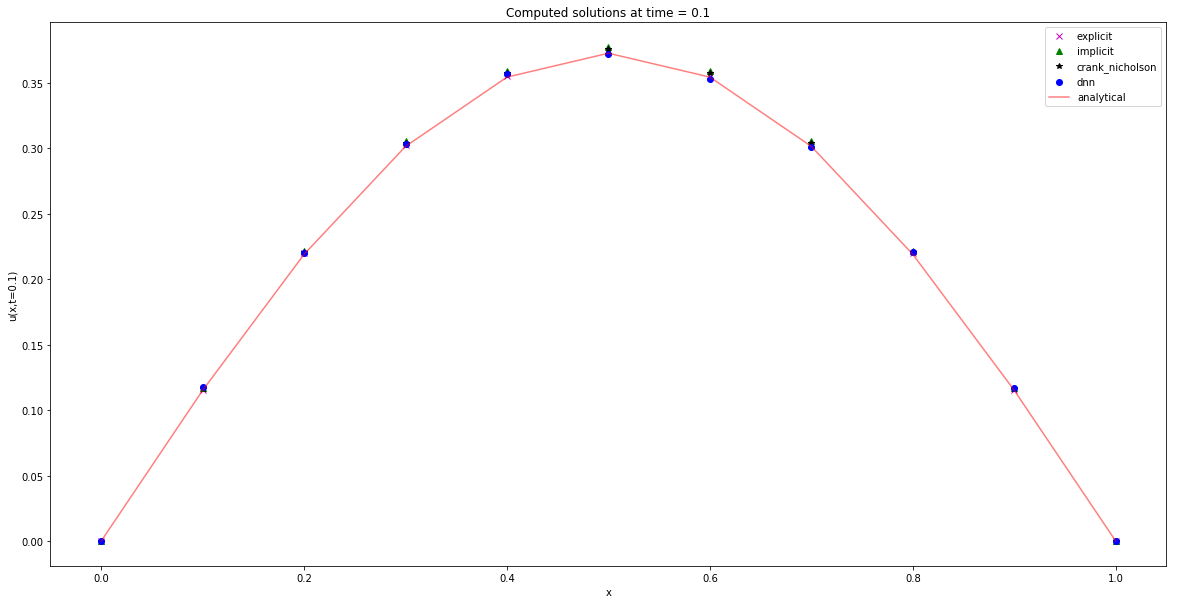

In [58]:
# Plot the slices
indx1 = 0
indx2 = int(Nt/2)
indx3 = Nt-1
t1 = t_np[indx1]
t2 = t_np[indx2]
t3 = t_np[indx3]

# Slice the results from the DNN
res1 = G_dnn[indx1,:]
res2 = G_dnn[indx2,:]
res3 = G_dnn[indx3,:]
# Slice the analytical results
res_analytical1 = G_analytic[indx1,:]
res_analytical2 = G_analytic[indx2,:]
res_analytical3 = G_analytic[indx3,:]

plt.figure(figsize=(20,10))
plt.title("Computed solutions at time = %g"%t3)
#plt.plot(x_np,u_explicit,'xm',label='explicit')
plt.plot(x_np,u_implicit,'^g',label='implicit')
plt.plot(x_np,u_crank_nich,'*k',label='crank_nicholson')
plt.plot(x_np, res3,'ob',label='dnn')
plt.plot(x_np,res_analytical3,'-r',alpha=0.5,label='analytical')
plt.legend()
plt.xlabel('x')
plt.ylabel('u(x,t=0.1)')
plt.savefig('finiteDiff_dnn_analytic_Nt=%d.png' % (Nt-1))
plt.show()

10
